In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd

##PREPARING THE DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/plantCLEF/metadata"

PlantCLEF2022_trusted_training_metadata.csv


In [ ]:
path = "/content/drive/MyDrive/plantCLEF/metadata/PlantCLEF2022_trusted_training_metadata.csv"
downloadPath = "/content/drive/MyDrive/plantCLEF/trusted_data"
data = pd.read_csv(path,delimiter=';')

KeyboardInterrupt: ignored

In [ ]:
data.head()

##GET INFO ABOUT THE METADATA

In [ ]:
data.isna().sum() #Check nan values at each column

In [ ]:
#We need just 2 columns for this step actually -> image_path class
data = data[["image_name","image_path","species"]]#drop irrelevant columns

In [ ]:
data["species"].value_counts()#get classes names and its amount

In [ ]:
speciesList = data["species"].value_counts().head(4320).index.tolist()

In [ ]:
def getParentDir(str1):
  return str1.split('/')[0]
data["image_path"] = data["image_path"].apply(getParentDir)

In [ ]:
data.head()

##CREATING SUBDIRECTORIES FOR TRAININGS

In [ ]:
import pathlib
dataset_url = "https://lab.plantnet.org/LifeCLEF/PlantCLEF2022/train/trusted/PlantCLEF2022_trusted_training_images_5.tar.gz"
data_dir = tf.keras.utils.get_file('images', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

38008585789/38008585789 [==============================] - 2387s 0us/step


In [ ]:
print(data_dir)

/root/.keras/datasets/images


In [ ]:
def is_convertible_to_int(obj):
    try:
        int(obj)
        return True
    except (ValueError, TypeError):
        return False

In [ ]:
"""
import shutil
files = list(data_dir.glob('*/*'))
for file in files:
  oldPath = os.path.abspath(file)
  folderName = oldPath.split('/')[-2]
  baseName = os.path.basename(file)
  if is_convertible_to_int(folderName):
    className = data.loc[data['image_path'] == folderName, 'species'].iloc[0]
  else:
    className = folderName
  newPath = oldPath.replace("/" + folderName +"/","/"+className+"/").replace(baseName,"")
  new_path  = os.path.join(newPath, baseName)
  os.renames(oldPath, new_path)
files = list(data_dir.glob('*'))
"""

KeyboardInterrupt: ignored

In [ ]:
""" if class_name not in speciesList:
      folder_path = os.path.dirname(old_path)
      if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        return
        """

In [ ]:
import multiprocessing
def process_file(file1):
    old_path = os.path.abspath(file1)
    folder_name = old_path.split('/')[-2]
    base_name = os.path.basename(file1)

    if is_convertible_to_int(folder_name):
        class_name = data.loc[data['image_path'] == folder_name, 'species'].iloc[0]
    else:
        class_name = folder_name
    new_path = old_path.replace("/" + folder_name +"/","/"+class_name+"/").replace(base_name,"")
    new_path = os.path.join(new_path, base_name)

    os.renames(old_path, new_path)

# Set up multiprocessing
num_processes = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=num_processes)

# Define the root directory containing the files
#data_dir = Path('your_data_directory_path')

# Get a list of all files
files = list(data_dir.glob('*/*'))

# Process the files in parallel using multiprocessing
pool.map(process_file, files)

# Close the multiprocessing pool
pool.close()
pool.join()

# Get a new list of files after the renaming
files = list(data_dir.glob('*'))

In [ ]:
speciesList = data["species"].value_counts().head(450).index.tolist()

In [ ]:
total = 0
for i in files:
  specie_name = os.path.basename(i)
  if specie_name in speciesList:
    total += 1
print(total)

100


In [ ]:
for i in files:
  specie_name = os.path.basename(i)
  if specie_name not in speciesList:
    shutil.rmtree(i)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:


# Create an ImageDataGenerator object with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation between -20 and 20 degrees
    width_shift_range=0.1,  # Randomly shift the width by 10%
    height_shift_range=0.1,  # Randomly shift the height by 10%
    shear_range=0.2,  # Shear the image by 20%
    zoom_range=0.2,  # Zoom in/out by 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill any newly created pixels with the nearest pixel value
)

# Iterate over the car brand folders
for brand_folder in os.listdir(data_dir):
    brand_path = os.path.join(data_dir, brand_folder)

    # Check if it is a directory
    if os.path.isdir(brand_path):
        print(f"Augmenting images in folder: {brand_folder}")

        # Load images from the brand folder
        image_files = [f for f in os.listdir(brand_path) if f.endswith('.jpg') or f.endswith('.png')]

        # Iterate over the image files and apply augmentations
        for image_file in image_files:
            image_path = os.path.join(brand_path, image_file)
            img = cv2.imread(image_path)  # Read the image using OpenCV

            # Reshape the image to match the expected input shape of the model
            img = img.reshape((1,) + img.shape)

            # Generate augmented images
            i = 0
            for batch in datagen.flow(img, batch_size=1, save_to_dir=None, save_prefix='', save_format='jpg'):
                i += 1
                augmented_image = batch[0].astype('uint8')  # Retrieve the augmented image
                augmented_image_path = os.path.join(brand_path, f"augmented_{image_file}")
                cv2.imwrite(augmented_image_path, augmented_image)  # Save the augmented image
                if i >= 10:  # Generate 10 augmented images per original image
                    break


Augmenting images in folder: Lasianthus verticillatus Merr. (Lour.)
Augmenting images in folder: Hexastylis virginica Small (L.)
Augmenting images in folder: Erica umbelliflora Klotzsch ex Benth.
Augmenting images in folder: Opercularia varia Hook.f.
Augmenting images in folder: Cotyledon cuneata Thunb.
Augmenting images in folder: Scutellaria arenicola Small
Augmenting images in folder: Cuspidia cernua B.L.Burtt (L.fil.)
Augmenting images in folder: Anthyllis lotoides L.
Augmenting images in folder: Struthiola macowanii C.H.Wright
Augmenting images in folder: Forgesia racemosa J.F.Gmel.
Augmenting images in folder: Limnocharis flava Buchenau (L.)
Augmenting images in folder: Tulipa patens C.Agardh ex Schult. & Schult.f.
Augmenting images in folder: Astragalus gracilis Nutt.
Augmenting images in folder: Lyperia antirrhinoides Hilliard (L.fil.)
Augmenting images in folder: Corybas dienemus D.L.Jones
Augmenting images in folder: Salacia madagascariensis DC. (Lam.)
Augmenting images in fo

In [ ]:
#TEK SEFERLİK İNDİRME
shutil.copytree(data_dir, downloadPath)

'/content/drive/MyDrive/plantCLEF/trusted_data'

In [ ]:
files = list(data_dir.glob('*'))

In [ ]:
print(len(files))


100


In [ ]:
data_dir ="/content/drive/MyDrive/plantCLEF/trusted_data"

In [ ]:
batch_sizes = [8,16,32]
dropout_rates = [0,0.25,0.5]
learning_rates = [0.01,0.005,0.001]
#DROPOUT/LEARNING RATE/BATCH SIZE
#000
#001
#002
#010
#011
#012
#020
#021
#022
#100
#101
#102
#110
#111
#112
#120
#121
#122
#200
#201
#202
#210
#211
#212
#220
#221
#222

In [ ]:
img_height,img_width=180,180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_sizes[2])

Found 21196 files belonging to 100 classes.
Using 16957 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_sizes[2])


Found 21196 files belonging to 100 classes.
Using 4239 files for validation.


In [ ]:
class_names = train_ds.class_names
#print(class_names)
num_classes = len(class_names)

In [ ]:
print(class_names)

['Actaea ludovici B.Boivin', 'Ageratina riparia R.King & H.Rob. (Regel)', 'Antennaria monocephala DC.', 'Anthyllis circinnata D.D.Sokoloff (L.)', 'Anthyllis lotoides L.', 'Arnica parryi A.Gray', 'Aspalathus cerrhantha Eckl. & Zeyh.', 'Aspalathus chortophila Eckl. & Zeyh.', 'Aspalathus crassisepala R.Dahlgren', 'Aspalathus perfoliata R.Dahlgren (Lam.)', 'Astraea lobata Klotzsch (L.)', 'Astragalus gracilis Nutt.', 'Astragalus sempervirens Lam.', 'Balanites aegyptiaca Delile (L.)', 'Blepharis maderaspatensis B.Heyne ex Roth (L.)', 'Blepharis petalidioides Vollesen', 'Blumea aromatica Wall. ex DC.', 'Blumea lanceolaria Druce (Roxb.)', 'Bonamia grandiflora Hallier fil. (A.Gray)', 'Bulbine praemorsa Spreng. (Jacq.)', 'Callisia repens L. (Jacq.)', 'Castanea mollissima Blume', 'Ceratocephala falcata Pers. (L.)', 'Chaenostoma campanulatum Benth.', 'Chironia linoides L.', 'Chrysopsis scabrella Torr. & A.Gray', 'Cordylanthus wrightii A.Gray', 'Corybas dienemus D.L.Jones', 'Corybas rotundifolius R

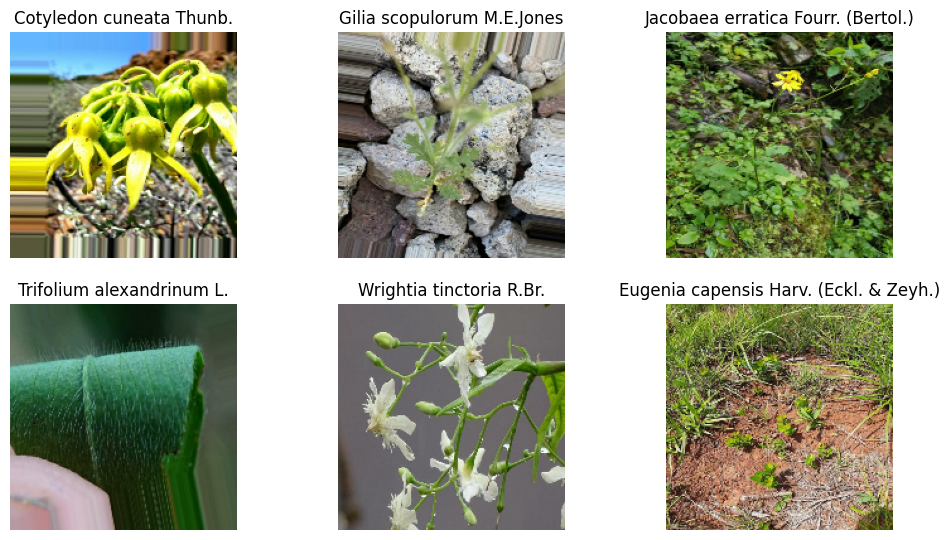

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Training The Model

In [ ]:
model = "resnet"


In [ ]:
resnet_model = Sequential()

if model == "resnet":
  pretrained_model = CustomModuleWrapper(tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(180, 180, 3),
    pooling='avg',
    classes=len(class_names),
    weights='imagenet'))
else:
  pretrained_model= tf.keras.applications.mobilenet.MobileNet(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=len(class_names),
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
#resnet_model.add(Dropout(0.25))
resnet_model.add(Dense(len(class_names), activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_45 (ModuleWr  (None, 2048)             0         
 apper)                                                          
                                                                 
 module_wrapper_46 (ModuleWr  (None, 512)              1049088   
 apper)                                                          
                                                                 
 module_wrapper_47 (ModuleWr  (None, 100)              51300     
 apper)                                                          
                                                                 
Total params: 24,688,100
Trainable params: 1,100,388
Non-trainable params: 23,587,712
_________________________________

In [ ]:
resnet_model.compile(optimizer=Adam(lr=learning_rates[1]),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=15
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_sizes[2]
)

Epoch 1/15
530/530 [==============================] - 293s 545ms/step - loss: 2.8752 - accuracy: 0.3209 - val_loss: 2.2446 - val_accuracy: 0.4310
Epoch 2/15
530/530 [==============================] - 275s 519ms/step - loss: 1.6218 - accuracy: 0.5707 - val_loss: 1.9093 - val_accuracy: 0.5077
Epoch 3/15
530/530 [==============================] - 275s 518ms/step - loss: 1.0973 - accuracy: 0.7039 - val_loss: 1.6626 - val_accuracy: 0.5610
Epoch 4/15
530/530 [==============================] - 270s 510ms/step - loss: 0.7605 - accuracy: 0.7941 - val_loss: 1.5613 - val_accuracy: 0.5914
Epoch 5/15
530/530 [==============================] - 274s 516ms/step - loss: 0.5352 - accuracy: 0.8503 - val_loss: 1.6041 - val_accuracy: 0.5950
Epoch 6/15
530/530 [==============================] - 269s 508ms/step - loss: 0.3829 - accuracy: 0.8973 - val_loss: 1.5727 - val_accuracy: 0.6096
Epoch 7/15
530/530 [==============================] - 249s 469ms/step - loss: 0.2737 - accuracy: 0.9279 - val_loss: 1.5381 -

##Evaluating The Model

In [ ]:
# Import the required libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Create the ResNet model
resnet_model = Sequential()
pretrained_model = ResNet50(include_top=False, input_shape=(180, 180, 3), pooling='avg')

# Freeze the weights of the pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(len(class_names), activation='softmax'))

resnet_model.compile(optimizer=Adam(lr=learning_rates[1]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs = 15
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_sizes[2])

# Save the model
model_path = '/content/drive/MyDrive/resnet_model.h5'
model_path2 = '/content/drive/MyDrive/resnet_model_weights.h5'
resnet_model.save(model_path)
resnet_model.save_weights(model_path2)
print("Model saved to:", model_path)


94765736/94765736 [==============================] - 0s 0us/step


Epoch 1/15
530/530 [==============================] - 253s 470ms/step - loss: 2.8577 - accuracy: 0.3299 - val_loss: 2.1781 - val_accuracy: 0.4364
Epoch 2/15
530/530 [==============================] - 235s 444ms/step - loss: 1.6074 - accuracy: 0.5778 - val_loss: 1.8165 - val_accuracy: 0.5322
Epoch 3/15
530/530 [==============================] - 235s 443ms/step - loss: 1.0895 - accuracy: 0.7030 - val_loss: 1.6733 - val_accuracy: 0.5636
Epoch 4/15
530/530 [==============================] - 232s 438ms/step - loss: 0.7567 - accuracy: 0.7947 - val_loss: 1.5628 - val_accuracy: 0.5848
Epoch 5/15
530/530 [==============================] - 232s 438ms/step - loss: 0.5180 - accuracy: 0.8611 - val_loss: 1.5841 - val_accuracy: 0.5924
Epoch 6/15
530/530 [==============================] - 231s 436ms/step - loss: 0.3676 - accuracy: 0.9012 - val_loss: 1.6025 - val_accuracy: 0.5964
Epoch 7/15
530/530 [==============================] - 231s 436ms/step - loss: 0.2633 - accuracy: 0.9292 - val_loss: 1.5191 -

In [ ]:
model_path3 = '/content/drive/MyDrive/resnet_model3.h5'
resnet_model.save(model_path3)

In [ ]:
import shutil
shutil.move('model.h5', '/content/drive/MyDrive/')

In [ ]:
from google.colab import files
files.download('model.h5')

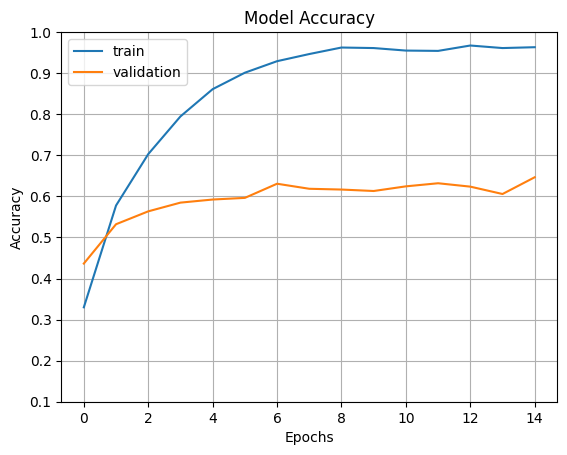

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

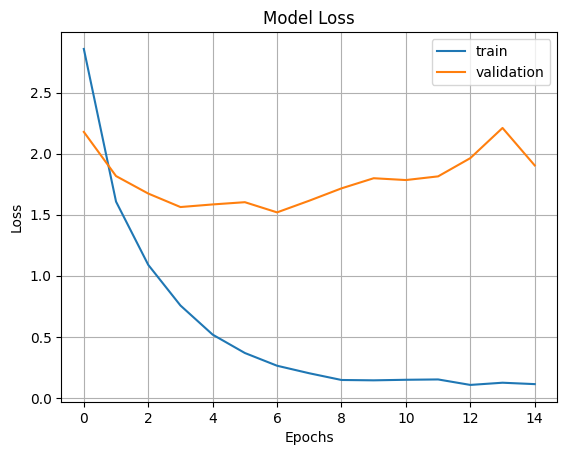

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

##Making Predictions

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
files = list(data_dir.glob('*/*'))

In [ ]:
print(str(files[0]))

/content/drive/MyDrive/plantCLEF/trusted_data/Lasianthus verticillatus Merr. (Lour.)/4d7cf23f46a17308ccd601018afb8e57fa30709a.jpg


In [ ]:
import cv2
image=cv2.imread(str(files[0]))
image_resized = cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

In [ ]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 0s 61ms/step
[[1.8120458e-21 2.8993111e-13 2.9082097e-18 1.8549635e-18 5.1068522e-18
  8.6397346e-23 2.0987216e-24 2.4068003e-18 1.2184787e-19 9.0070786e-20
  8.2347317e-14 1.6319085e-22 1.0234865e-25 4.4062985e-17 4.8931706e-16
  4.3914614e-26 5.7293038e-15 2.9206213e-15 2.5360645e-17 1.0456323e-20
  1.6280815e-18 6.5080890e-17 1.4608418e-23 3.4866382e-18 3.2360034e-23
  2.9419028e-21 1.0557782e-25 7.4649163e-18 1.7211907e-19 1.0039103e-22
  3.3925480e-21 8.2901123e-21 6.4902582e-26 8.7495385e-18 1.7490311e-17
  3.9443429e-18 6.8433459e-19 1.4984735e-20 1.1508943e-26 4.9182822e-17
  5.0147728e-16 2.8056166e-16 4.4318511e-26 3.2784984e-15 8.9843080e-13
  1.0000000e+00 1.8261779e-17 1.7956792e-17 2.6300167e-25 7.1311480e-18
  7.6045832e-23 2.2288748e-18 1.2894262e-09 1.6278136e-19 7.1549593e-19
  2.9021525e-11 3.7926502e-15 1.9695280e-18 3.3437980e-23 1.1549446e-19
  2.2971700e-12 1.9659422e-12 2.7710627e-13 1.7773750e-16 6.5244220e-24
  7.6450070e

In [ ]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is Forgesia racemosa J.F.Gmel.


In [ ]:
print(class_names)

['Actaea ludovici B.Boivin', 'Ageratina riparia R.King & H.Rob. (Regel)', 'Antennaria monocephala DC.', 'Anthyllis circinnata D.D.Sokoloff (L.)', 'Anthyllis lotoides L.', 'Arnica parryi A.Gray', 'Aspalathus cerrhantha Eckl. & Zeyh.', 'Aspalathus chortophila Eckl. & Zeyh.', 'Aspalathus crassisepala R.Dahlgren', 'Aspalathus perfoliata R.Dahlgren (Lam.)', 'Astraea lobata Klotzsch (L.)', 'Astragalus gracilis Nutt.', 'Astragalus sempervirens Lam.', 'Balanites aegyptiaca Delile (L.)', 'Blepharis maderaspatensis B.Heyne ex Roth (L.)', 'Blepharis petalidioides Vollesen', 'Blumea aromatica Wall. ex DC.', 'Blumea lanceolaria Druce (Roxb.)', 'Bonamia grandiflora Hallier fil. (A.Gray)', 'Bulbine praemorsa Spreng. (Jacq.)', 'Callisia repens L. (Jacq.)', 'Castanea mollissima Blume', 'Ceratocephala falcata Pers. (L.)', 'Chaenostoma campanulatum Benth.', 'Chironia linoides L.', 'Chrysopsis scabrella Torr. & A.Gray', 'Cordylanthus wrightii A.Gray', 'Corybas dienemus D.L.Jones', 'Corybas rotundifolius R

In [ ]:
print(pred)

[[1.81660397e-07 7.63024843e-08 3.78925324e-16 3.07824491e-12
  2.00336487e-07 8.91612045e-12 2.30669975e-12 1.54385968e-14
  3.35794272e-13 1.83313586e-12 3.00551982e-13 1.50300203e-14
  1.18368705e-04 3.82425026e-16 4.09170383e-07 1.67413668e-06
  6.07695982e-09 1.16841704e-06 1.10469784e-08 5.31451551e-05
  2.16591434e-09 6.84221430e-12 2.36104393e-06 5.88385556e-05
  4.70519890e-09 2.14072242e-02 8.43892619e-02 2.13737732e-15
  3.62112413e-14 5.22305541e-08 2.26356683e-10 4.48445371e-06
  1.90624339e-12 1.85211735e-16 3.68036560e-18 3.55041842e-12
  2.92378766e-09 1.55354768e-15 1.72042285e-13 4.89749408e-10
  6.77314038e-11 1.02416490e-14 1.14163290e-13 9.15212510e-08
  7.50551117e-05 1.68278433e-07 5.35920449e-03 2.29673225e-10
  2.93433141e-06 5.77102439e-13 3.39242923e-09 3.03472127e-08
  6.08362753e-13 7.31183558e-09 1.04867962e-04 1.34161557e-04
  1.35326073e-09 4.73465752e-06 3.62192024e-03 3.83598465e-11
  1.45707468e-16 7.48144764e-13 2.10812745e-09 4.38456702e-08
  2.2586

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the predicted classes for the validation data
y_pred = np.argmax(resnet_model.predict(val_ds), axis=1)
# Get the true classes for the validation data
y_true = np.argmax(val_ds.class_names, axis=0)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

print(confusion_mtx)


18/18 [==============================] - 2s 67ms/step


TypeError: ignored